<a href="https://colab.research.google.com/github/MohamadRayi/MachineLearningTasks/blob/main/Feature_agglomeration_vs_univariate_selection_Rayi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mohamad Rayi Dwi Putra
1103213070
Task Lecture 6 Clustering

**Feature agglomeration vs. univariate selection**

In [5]:
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from joblib import Memory
from scipy import linalg, ndimage

from sklearn import feature_selection
from sklearn.cluster import FeatureAgglomeration
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline

**Set parameters**

In [6]:
import numpy as np

n_samples = 200
size = 40  # image size
roi_size = 15
snr = 5.0
np.random.seed(0)

coef = np.zeros((size, size))
coef[0:roi_size, 0:roi_size] = -1.0
coef[-roi_size:, -roi_size:] = 1.0

X = np.random.randn(n_samples, size**2)
for x in X:  # smooth data
    x[:] = ndimage.gaussian_filter(x.reshape(size, size), sigma=1.0).ravel()
X -= X.mean(axis=0)
X /= X.std(axis=0)

y = np.dot(X, coef.ravel())

noise = np.random.randn(y.shape[0])
noise_coef = (linalg.norm(y, 2) / np.exp(snr / 20.0)) / linalg.norm(noise, 2)
y += noise_coef * noise


**Generate data**

In [7]:
import numpy as np
from scipy import ndimage

# Membuat koefisien untuk regresi linier
coef = np.zeros((size, size))
coef[0:roi_size, 0:roi_size] = -1.0
coef[-roi_size:, -roi_size:] = 1.0

# Membuat data X dengan noise Gaussian
X = np.random.randn(n_samples, size ** 2)

# Menghaluskan data X
for x in X:
    x[:] = ndimage.gaussian_filter(x.reshape(size, size), sigma=1.0).ravel()

# Standarisasi data X
X -= X.mean(axis=0)
X /= X.std(axis=0)

# Membuat data target y
y = np.dot(X, coef.ravel())

# Memeriksa bentuk data yang dihasilkan
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (200, 1600)
Shape of y: (200,)


**add noise**

In [8]:
import numpy as np
from scipy import linalg

# Membuat noise
noise = np.random.randn(y.shape[0])

# Menghitung koefisien untuk menormalkan noise
noise_coef = (linalg.norm(y, 2) / np.exp(snr / 20.0)) / linalg.norm(noise, 2)

# Menambahkan noise ke data target y
y += noise_coef * noise

# Memeriksa bentuk data yang dihasilkan
print("Shape of y after adding noise:", y.shape)


Shape of y after adding noise: (200,)


**Compute the coefs of a Bayesian Ridge with GridSearch**

In [9]:
from sklearn.model_selection import KFold
from sklearn.linear_model import BayesianRidge
import tempfile
from joblib import Memory

cv = KFold(2)  # cross-validation generator for model selection
ridge = BayesianRidge()
cachedir = tempfile.mkdtemp()
mem = Memory(location=cachedir, verbose=1)


**Ward agglomeration followed by BayesianRidge**

In [10]:
from sklearn.cluster import FeatureAgglomeration
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.image import grid_to_graph

connectivity = grid_to_graph(n_x=size, n_y=size)
ward = FeatureAgglomeration(n_clusters=10, connectivity=connectivity, memory=mem)
clf = Pipeline([("ward", ward), ("ridge", ridge)])
# Select the optimal number of parcels with grid search
clf = GridSearchCV(clf, {"ward__n_clusters": [10, 20, 30]}, n_jobs=1, cv=cv)
clf.fit(X, y)  # set the best parameters
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_)
coef_agglomeration_ = coef_.reshape(size, size)


________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[-0.433491, ..., -0.518734],
       ...,
       [ 0.801232, ..., -2.210749]]), connectivity=<1600x1600 sparse matrix of type '<class 'numpy.int64'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[0.935706, ..., 1.277465],
       ...,
       [0.317433, ..., 1.021728]]), connectivity=<1600x1600 sparse matrix of type '<class 'numpy.int64'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.2s, 0.0min
______________________________________________

**Anova univariate feature selection followed by BayesianRidge**

In [11]:
f_regression = mem.cache(feature_selection.f_regression)  # caching function
anova = feature_selection.SelectPercentile(f_regression)
clf = Pipeline([("anova", anova), ("ridge", ridge)])
# Select the optimal percentage of features with grid search
clf = GridSearchCV(clf, {"anova__percentile": [5, 10, 20]}, cv=cv)
clf.fit(X, y)  # set the best parameters
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_.reshape(1, -1))
coef_selection_ = coef_.reshape(size, size)


________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[-0.433491, ...,  0.801232],
       ...,
       [-0.518734, ..., -2.210749]]), 
array([-77.324109, ..., -38.072886]))
_____________________________________________________f_regression - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[0.935706, ..., 0.317433],
       ...,
       [1.277465, ..., 1.021728]]), array([  37.778886, ..., -104.407567]))
_____________________________________________________f_regression - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[ 0.935706, ...,  0.317433],
       ...,
       [-0.518734,

**Inverse the transformation to plot the results on an image**

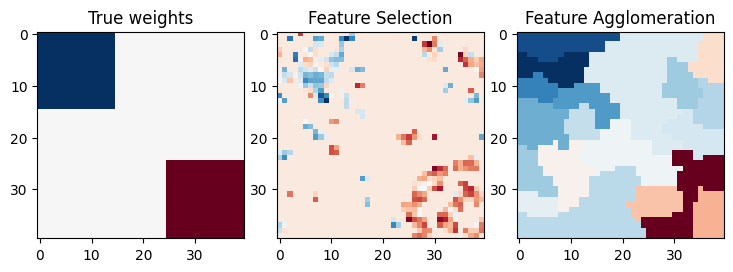

In [12]:
plt.close("all")
plt.figure(figsize=(7.3, 2.7))
plt.subplot(1, 3, 1)
plt.imshow(coef, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("True weights")
plt.subplot(1, 3, 2)
plt.imshow(coef_selection_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Selection")
plt.subplot(1, 3, 3)
plt.imshow(coef_agglomeration_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Agglomeration")
plt.subplots_adjust(0.04, 0.0, 0.98, 0.94, 0.16, 0.26)
plt.show()
